In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time as time

import torch
from astropy.io import fits
from astropy.utils.data import download_file

from mpol import (
    coordinates,
    crossval,
    datasets,
    gridding,
    images,
    fourier,
    losses,
    precomposed,
)

from training_func import train

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [48]:
# input parameters
###########################################################################################################################################
fname = '../data/visibilities/R_Dor_concatenated_visibilities.npz' # path to the .npz file containing the observed visibilities
cell_size = 0.001 # arcseconds
npix = 512 # number of pixels per image axis
learning_rate = 0.3 # learning rate for the optimizer
# n_iter = 25 # number of iterations for the optimizer

start_from_dirty_image = False # If True, the initial BaseCube image is set to the dirty image, else to the default flat image.
###########################################################################################################################################

In [50]:
# this is a multi-channel dataset... for demonstration purposes we'll use
# only the central, single channel
d = np.load(fname)
uu = d["uu"]
vv = d["vv"]
weight = d["weight"]
data = d["data"]
data_re = np.real(data)
data_im = np.imag(data)

# define the image dimensions, making sure they are big enough to fit all
# of the expected emission
coords = coordinates.GridCoords(cell_size=cell_size, npix=npix)
averager = gridding.DataAverager(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im
)

# export to PyTorch dataset
dset = averager.to_pytorch_dataset(max_scatter=1.5)

dset

GriddedDataset()

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

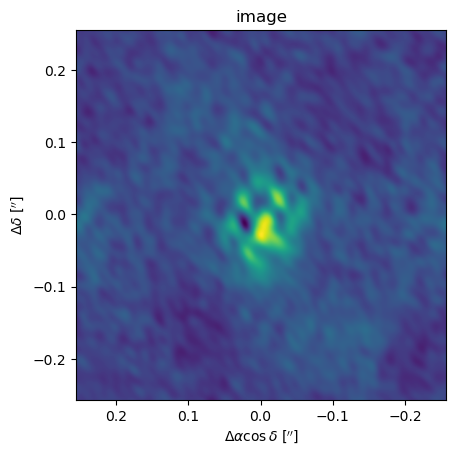

In [52]:
imager = gridding.DirtyImager(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im
)

# Show the dirty image
img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0, max_scatter=1.5)
kw = {"origin": "lower", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
ax.imshow(np.squeeze(img), **kw)
ax.set_title("image")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

(-0.1, 0.1)

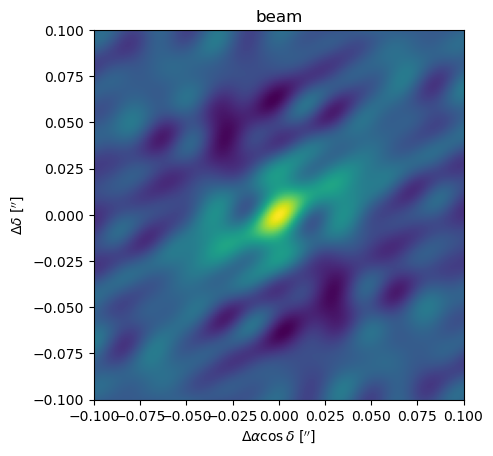

In [54]:
# Show the dirty beam
img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0)
kw = {"origin": "lower", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
ax.imshow(np.squeeze(beam), **kw)
ax.set_title("beam")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)

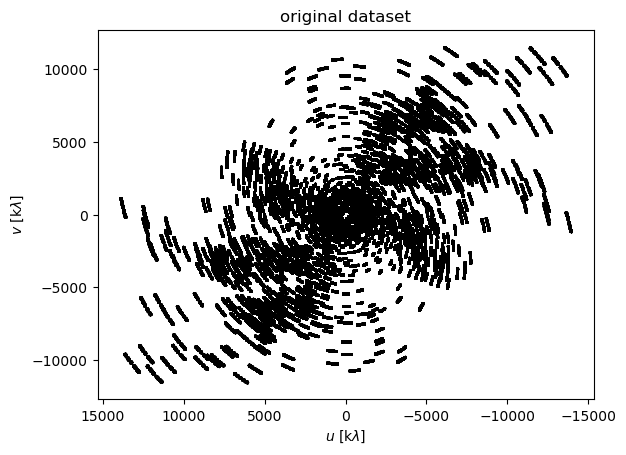

In [55]:
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=1.5, rasterized=True, linewidths=0.0, c="k")
ax.scatter(
    -uu, -vv, s=1.5, rasterized=True, linewidths=0.0, c="k"
)  # and Hermitian conjugates
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
ax.set_title("original dataset")
ax.invert_xaxis()

In [56]:
# create a radial and azimuthal partition
dartboard = datasets.Dartboard(coords=coords)

# create cross validator using this "dartboard"
k = 5
cv = crossval.DartboardSplitGridded(dset, k, dartboard=dartboard, seed=42)

# ``cv`` is a Python iterator, it will return a ``(train, test)`` pair of ``GriddedDataset``s for each iteration.
# Because we'll want to revisit the individual datasets
# several times in this tutorial, we're storeing them into a list
k_fold_datasets = [(train, test) for (train, test) in cv]

# k_fold_datasets[0][0].vis_gridded.shape

k_fold_datasets[0][0].ground_mask[0]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

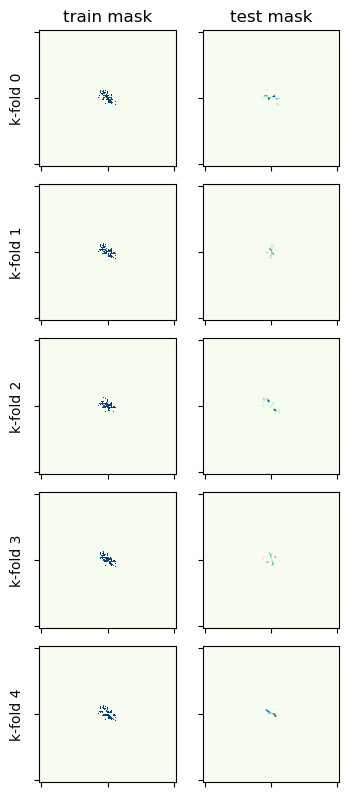

In [57]:
fig, ax = plt.subplots(nrows=k, ncols=2, figsize=(4, 10))

for i, (train_subset, test_subset) in enumerate(k_fold_datasets):

    # train_subset and test_subset are `GriddedDataset`s

    train_mask = train_subset.ground_mask[0]
    test_mask = test_subset.ground_mask[0]

    ax[i, 0].imshow(
        train_mask.detach().numpy(),
        interpolation="none",
        origin="lower",
        extent=coords.vis_ext,
        cmap="GnBu",
    )

    ax[i, 1].imshow(
        test_mask.detach().numpy(), origin="lower", extent=coords.vis_ext, cmap="GnBu"
    )

    ax[i, 0].set_ylabel("k-fold {:}".format(i))

ax[0, 0].set_title("train mask")
ax[0, 1].set_title("test mask")

for a in ax.flatten():
    a.xaxis.set_ticklabels([])
    a.yaxis.set_ticklabels([])

fig.subplots_adjust(left=0.15, hspace=0.0, wspace=0.2)

In [58]:
def test(model, dset):
    model.train(False)
    # evaluate test score
    vis = model()
    loss = losses.nll_gridded(vis, dset)
    return loss.item()

In [59]:
def cross_validate(config):
    """
    config is a dictionary that should contain ``lr``, ``lambda_sparsity``, ``lambda_TV``, ``epochs``
    """
    test_scores = []

    for k_fold, (train_dset, test_dset) in enumerate(k_fold_datasets):

        # create a new model and optimizer for this k_fold
        rml = precomposed.SimpleNet(coords=coords, nchan=train_dset.nchan)
        optimizer = torch.optim.Adam(rml.parameters(), lr=config["lr"])

        # train for a while
        # train(rml, train_dset, config, optimizer)
        loss_tracker = train(rml=rml, dset=train_dset, hyperparams_config=config, optimizer=optimizer)
        # evaluate the test metric
        test_scores.append(test(rml, test_dset))

    # aggregate all test scores and sum to evaluate cross val metric
    test_score = np.sum(np.array(test_scores))

    return test_score

In [64]:
def train_and_image(pars):
    rml = precomposed.SimpleNet(coords=coords, nchan=dset.nchan)
    print("Model created")
    optimizer = torch.optim.Adam(rml.parameters(), lr=pars["lr"])
    writer = SummaryWriter()
    # train(rml, dset, pars, optimizer, writer=writer)
    print("Training the model...")
    loss_tracker = train(rml=rml, dset=dset, hyperparams_config=pars, optimizer=optimizer, writer=writer)
    writer.close()

    img_ext = rml.coords.img_ext
    fig, ax = plt.subplots()
    ax.imshow(
        np.squeeze(rml.icube.sky_cube.detach().numpy()), origin="lower", extent=img_ext
    )
    return fig, ax

### Train with a given set of parameters

Here we can test different parameters

Cross validation score: 19.27769160877761
Model created
Training the model...


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

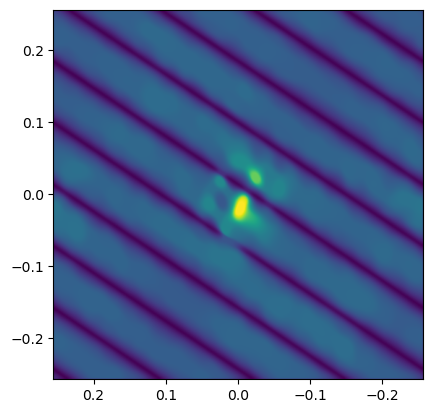

In [65]:
pars = {'lr': 0.5,
        'lambda_sparsity': 1.0e-4,
        'lambda_TV': 1.0e-4,
        'entropy': 1.0e-4,
        'prior_intensity': 1.0e-7,
        'TSV': 1.0e-6,
        "epochs": 600}

print("Cross validation score:", cross_validate(pars))
train_and_image(pars)

In [14]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
# Define missing variables
lambda_sparsity_space = np.logspace(-6, -2, 4)
lambda_TV_space = np.logspace(-8, -4, 3)
# lambda_TV_space = np.array([1.0e-6])
entropy_space = np.logspace(-7, -2, 4)
TSV_space = np.logspace(-6, -2, 4)
torch.set_num_threads(10)


# Fix code block
cv_dataframe = pd.DataFrame(columns=['lambda_sparsity', 'lambda_TV', 'entropy', 'TSV', 'cross_val_score'])
parameter_total = len(lambda_sparsity_space)*len(lambda_TV_space)*len(entropy_space)*len(TSV_space)
start_time = time.time()
for sparsity_index, lambda_sparsity in enumerate(lambda_sparsity_space):
    for TV_index, lambda_TV in enumerate(lambda_TV_space):
        for entropy_index, entropy in enumerate(entropy_space):
            for TSV_index, TSV in enumerate(TSV_space):
                parameter_count=sparsity_index*len(lambda_TV_space)*len(entropy_space)*len(TSV_space)+TV_index*len(entropy_space)*len(TSV_space)+entropy_index*len(TSV_space)+TSV_index+1
                # print(f"[{parameter_count}/{parameter_total}]")
                run_time_start = time.time()
                pars = {'lr': 0.5,
                        'lambda_sparsity': lambda_sparsity,
                        'lambda_TV': lambda_TV,
                        'entropy': entropy,
                        'prior_intensity': 1.0e-7,
                        'TSV': TSV,
                        "epochs": 600}
                cv_score = cross_validate(pars)
                print("[{}/{}] --> CV: {:.2f}, log_TSV:{:.1e}, log_entropy:{:.1e}, log_TV:{:.1e}, log_sparsity:{:.1e}".format(parameter_count, parameter_total, cv_score, np.log10(TSV), np.log10(entropy), np.log10(lambda_TV), np.log10(lambda_sparsity)))
                cv_dataframe = pd.concat([cv_dataframe, pd.DataFrame({'lambda_sparsity': lambda_sparsity, 'lambda_TV': lambda_TV, 'entropy': entropy, 'TSV': TSV, 'cross_val_score': cv_score}, index=[0])], ignore_index=True)
                # train_and_image(pars)
                run_time_end = time.time()
                predicted_time = (time.time()-start_time)*(parameter_total-parameter_count)/(parameter_count)
                # print("runtime: {:.1f} seconds \t remaining time: {:.1f} minutes\n".format(run_time_end-run_time_start, predicted_time/60))

end_time = time.time()
print("Time taken for cross validation:{:.2f} minutes".format((end_time-start_time)/60))
cv_dataframe.to_csv('cv_dataframe.csv', index=True)

[1/192] --> CV: 110.92, log_TSV:-6.0e+00, log_entropy:-7.0e+00, log_TV:-8.0e+00, log_sparsity:-6.0e+00
[2/192] --> CV: 52.39, log_TSV:-4.7e+00, log_entropy:-7.0e+00, log_TV:-8.0e+00, log_sparsity:-6.0e+00
[3/192] --> CV: 33.99, log_TSV:-3.3e+00, log_entropy:-7.0e+00, log_TV:-8.0e+00, log_sparsity:-6.0e+00
[4/192] --> CV: 102.34, log_TSV:-2.0e+00, log_entropy:-7.0e+00, log_TV:-8.0e+00, log_sparsity:-6.0e+00
[5/192] --> CV: 43.87, log_TSV:-6.0e+00, log_entropy:-5.3e+00, log_TV:-8.0e+00, log_sparsity:-6.0e+00
[6/192] --> CV: 25.58, log_TSV:-4.7e+00, log_entropy:-5.3e+00, log_TV:-8.0e+00, log_sparsity:-6.0e+00
[7/192] --> CV: 20.81, log_TSV:-3.3e+00, log_entropy:-5.3e+00, log_TV:-8.0e+00, log_sparsity:-6.0e+00
[8/192] --> CV: 78.31, log_TSV:-2.0e+00, log_entropy:-5.3e+00, log_TV:-8.0e+00, log_sparsity:-6.0e+00
[9/192] --> CV: 9.72, log_TSV:-6.0e+00, log_entropy:-3.7e+00, log_TV:-8.0e+00, log_sparsity:-6.0e+00
[10/192] --> CV: 9.28, log_TSV:-4.7e+00, log_entropy:-3.7e+00, log_TV:-8.0e+00, l

In [15]:
cv_dataframe.to_csv('cv_dataframe.csv', index=True)

In [16]:
cv_dataframe

,lambda_sparsity,lambda_TV,entropy,TSV,cross_val_score
0,0.000001,1.000000e-08,1.000000e-07,0.000001,110.924676
1,0.000001,1.000000e-08,1.000000e-07,0.000022,52.391749
2,0.000001,1.000000e-08,1.000000e-07,0.000464,33.990549
3,0.000001,1.000000e-08,1.000000e-07,0.010000,102.335421
4,0.000001,1.000000e-08,4.641589e-06,0.000001,43.868884
...,...,...,...,...,...
187,0.010000,1.000000e-04,2.154435e-04,0.010000,131.106707
188,0.010000,1.000000e-04,1.000000e-02,0.000001,131.589751
189,0.010000,1.000000e-04,1.000000e-02,0.000022,131.589751
190,0.010000,1.000000e-04,1.000000e-02,0.000464,131.589752


In [17]:
cv_dataframe.sort_values(by='cross_val_score', ascending=True)

,lambda_sparsity,lambda_TV,entropy,TSV,cross_val_score
128,0.000464,1.000000e-04,1.000000e-07,0.000001,8.415104
132,0.000464,1.000000e-04,4.641589e-06,0.000001,8.436908
129,0.000464,1.000000e-04,1.000000e-07,0.000022,8.441239
133,0.000464,1.000000e-04,4.641589e-06,0.000022,8.464305
40,0.000001,1.000000e-04,2.154435e-04,0.000001,8.484306
...,...,...,...,...,...
60,0.000022,1.000000e-08,1.000000e-02,0.000001,132.094555
29,0.000001,1.000000e-06,1.000000e-02,0.000022,132.099235
13,0.000001,1.000000e-08,1.000000e-02,0.000022,132.099337
28,0.000001,1.000000e-06,1.000000e-02,0.000001,132.099895


In [18]:
idx = cv_dataframe['cross_val_score'].idxmin()
print("lowest cross validation score:\n", cv_dataframe.loc[idx])

lowest cross validation score:
 lambda_sparsity    4.641589e-04
lambda_TV          1.000000e-04
entropy            1.000000e-07
TSV                1.000000e-06
cross_val_score    8.415104e+00
Name: 128, dtype: float64


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

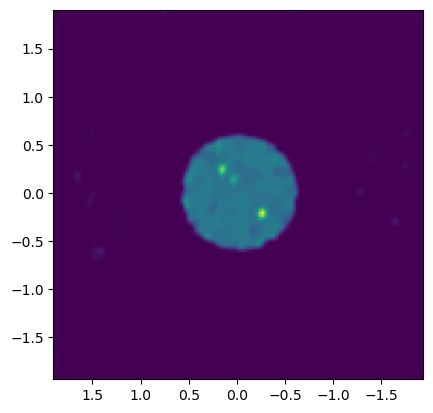

In [19]:
pars = {'lr': 0.5,
        'lambda_sparsity': cv_dataframe['lambda_sparsity'][idx],
        'lambda_TV': cv_dataframe['lambda_TV'][idx],
        'entropy': cv_dataframe['entropy'][idx],
        'prior_intensity': 1.0e-7,
        'TSV': cv_dataframe['TSV'][idx],
        "epochs": 600}

train_and_image(pars)

     lambda_sparsity  entropy      TSV  cross_val_score
128         4.64e-04 1.00e-07 1.00e-06         8.42e+00
132         4.64e-04 4.64e-06 1.00e-06         8.44e+00
129         4.64e-04 1.00e-07 2.15e-05         8.44e+00
133         4.64e-04 4.64e-06 2.15e-05         8.46e+00
40          1.00e-06 2.15e-04 1.00e-06         8.48e+00
..               ...      ...      ...              ...
60          2.15e-05 1.00e-02 1.00e-06         1.32e+02
29          1.00e-06 1.00e-02 2.15e-05         1.32e+02
13          1.00e-06 1.00e-02 2.15e-05         1.32e+02
28          1.00e-06 1.00e-02 1.00e-06         1.32e+02
12          1.00e-06 1.00e-02 1.00e-06         1.32e+02

[192 rows x 4 columns]


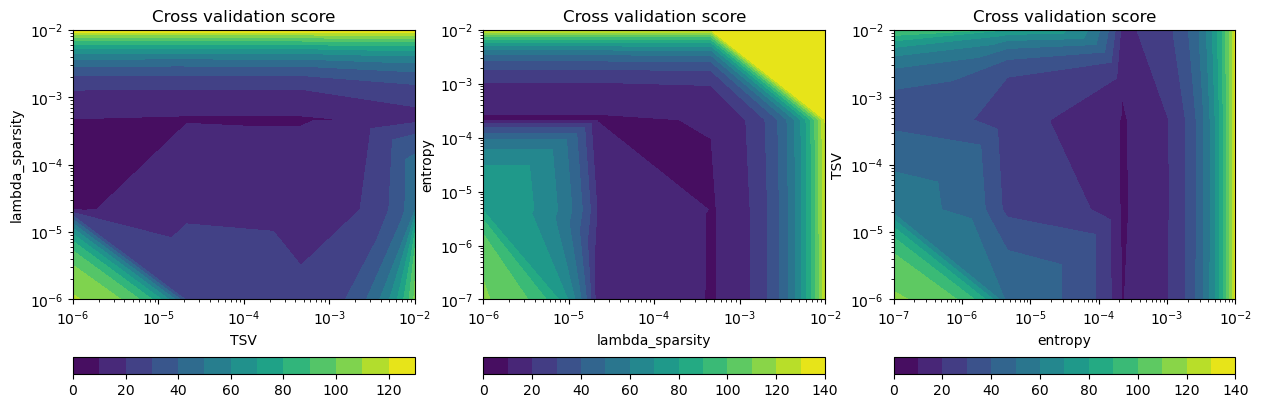

In [20]:
pd.set_option('display.float_format', lambda x: '%.2e' % x)
interest_cols = ['lambda_sparsity', 'entropy', 'TSV', 'cross_val_score']
df= cv_dataframe
df_interest = df[interest_cols]
interest_cols = ['lambda_sparsity', 'entropy', 'TSV']
print(df_interest.sort_values(by='cross_val_score', ascending=True))

# plot a contour plot for each two parameter combination and the cross validation score. 
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(interest_cols):
    X = df_interest[interest_cols[i-1]]
    Y = df_interest[interest_cols[i]]
    Z = df_interest['cross_val_score']
    ax[i].tricontourf(X, Y, Z, levels=14, cmap='RdYlBu')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel(interest_cols[i-1])
    ax[i].set_ylabel(interest_cols[i])
    ax[i].set_title('Cross validation score')
    fig.colorbar(ax[i].tricontourf(X, Y, Z, levels=14), ax=ax[i], orientation='horizontal')
plt.show()